In [1]:
ACTION_LABELS = ['→', '←', '↓', '↑']
width, height = 8, 8
obstacle_positions = [(2, 2), (5, 3), (1, 3), (3,5)]

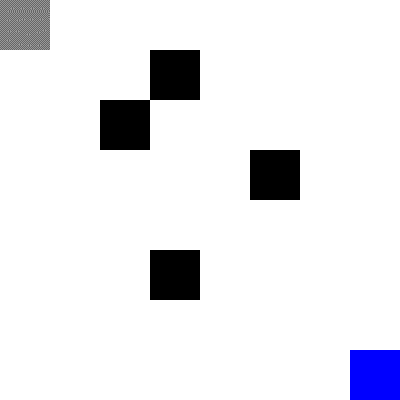

In [2]:
from maze import MazeEnv, ACTIONS
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
from IPython import display
import numpy as np
from tqdm import tqdm

filename = 'imagedraw.gif'
images = []
env = MazeEnv(width, height, (0, 0), (width-1, height-1), obstacle_positions)
state = env.reset()
done = False
reward_sum = 0.0

img = env.render()
im = Image.fromarray(img)
im = im.resize((400, 400), resample=0)
images.append(im)

while not done:
    action = np.random.choice(len(ACTIONS))
    state, reward, done, _ = env.step(action)
    # print(state, reward, done)
    reward_sum += reward
    img = env.render()
    im = Image.fromarray(img)
    im = im.resize((400, 400), resample=0)
    images.append(im)
    
images[0].save(filename,
               save_all=True, append_images=images[1:],
               optimize=False, duration=40, loop=0)


# %%
display.Image(filename)

In [3]:
from collections import defaultdict

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def generate_episode_from_Q(env, Q, epsilon):
    nA = env.action_space.n
    episode = []
    state = env.reset()
    done = False
    while not done:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))                                     if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [4]:
env = MazeEnv(width, height, (0, 0), (width-1, height-1), obstacle_positions)
num_episodes = 50000
alpha = 0.05

gamma= 0.9
eps_start=1.0
eps_decay=.99999
eps_min=0.01

# Main loop
nA = env.action_space.n

# Initialization
Q = defaultdict(lambda: np.zeros(nA))
epsilon = eps_start
# loop over episodes
for i_episode in tqdm(range(num_episodes)):
    epsilon = max(epsilon * eps_decay, eps_min)
    episode = generate_episode_from_Q(env, Q, epsilon)
    Q = update_Q(env, episode, Q, alpha, gamma)
policy = dict((k, np.argmax(v)) for k, v in Q.items())

100%|██████████| 50000/50000 [09:23<00:00, 88.76it/s] 


In [5]:
import pandas as pd
pd.DataFrame(Q).T.sort_index()

0          1          2          3
0 0 -12.018091 -17.859428 -13.395272 -18.654808
  1 -13.625404 -14.031513 -11.383592 -17.057056
  2 -13.211282 -12.936371 -12.944942 -17.330631
  3 -11.559335 -12.925028 -16.487239 -16.128908
  4  -9.480278 -12.186983 -10.373116 -15.782376
  5  -9.289017  -9.891061  -8.086927 -13.350505
  6 -10.479215  -9.265687  -7.381065 -13.222754
  7 -14.706858  -9.555467  -7.293641 -14.584422
1 0 -12.295928 -17.029388 -12.556389 -13.273994
  1 -13.433855 -11.930150 -11.484693 -13.855344
  2 -18.290493 -11.946422 -16.775530 -12.395590
  4  -9.470006 -13.879118 -10.427959 -11.493512
  5  -6.515585 -10.768525  -7.680057  -8.896445
  6  -8.030862  -6.934649  -5.472498  -9.421047
  7 -12.071842  -7.016603  -5.913243 -10.241397
2 0 -12.321593 -15.291406 -11.231504 -12.713639
  1 -14.210303 -12.212891 -10.289229 -12.156208
  3  -9.200643 -12.979307  -9.125460 -14.053423
  4  -7.952015  -9.952379  -8.469443 -10.446960
  5  -7.009645  -7.633622 -10.870811  -6.811592
  6  -6.190374  -8.045210  -3.484304  -7.099676
  7  -7.164771  -5.520942  -2.727312  -8.640794
3 0 -10.210792 -14.870777 -11.434973 -11.667825
  1  -9.835097 -10.852316  -9.918464 -11.280775
  2  -8.908806  -9.719806  -9.247016 -12.532504
  3  -7.878590 -10.899728  -8.389179 -10.808089
  4 -12.673541  -8.971094  -7.322887  -8.648555
  6  -2.134829  -5.832939  -0.382085  -6.073293
  7  -7.827716  -4.263338   0.429160  -4.826582
4 0  -9.780887 -16.322144  -9.712728 -10.780572
  1 -10.700865 -10.753190  -8.912317 -10.758976
  2  -9.189510 -10.797286  -7.934117 -10.150774
  3  -5.674328  -8.803325 -12.003055  -9.508089
  4  -4.947527  -7.580520  -5.148395  -8.872133
  5  -1.886656  -6.155957  -0.367980  -5.993726
  6  -0.607546  -2.139196   2.016540  -3.312559
  7  -3.755790  -0.711773   2.815716  -3.625136
5 0  -8.354133 -14.901462  -9.457952 -10.512932
  1  -7.403182  -9.915345  -9.660080  -9.706578
  2 -10.202754  -7.715218  -5.879035  -8.559705
  4  -1.227589  -7.081552  -1.275230  -4.684946
  5   3.757651  -3.098071   0.761353  -2.115990
  6   4.015825  -0.832793   8.147997  -0.404208
  7   0.725422   3.339909  10.839846  -1.420008
6 0  -9.355565 -13.880019  -9.320424  -9.398087
  1  -5.763075 -10.692784  -9.874897  -9.977982
  2  -3.612782  -6.410472  -6.060500  -7.466762
  3  -0.370051  -5.028953  -2.255078  -7.937017
  4   3.588877  -4.359355   0.125622  -2.957622
  5   4.715410  -1.735320   5.277922  -0.065965
  6  11.705856   1.638495   9.902843   3.591836
  7   6.357117   6.224413  20.000000   5.955000
7 0  -7.358776 -13.409069 -14.044611  -9.325866
  1  -5.657580 -11.220812 -11.515383  -7.110507
  2  -4.254036  -8.420975  -9.766777  -6.494112
  3  -0.271684  -6.627786  -9.746129  -2.410179
  4   4.918555  -4.662993  -3.289338   0.451224
  5  11.514357   2.005994   2.586721   1.759697
  6  20.000000   6.035363   6.270529   6.938746

In [6]:
env = MazeEnv(width, height, (0, 0), (width-1, height-1), obstacle_positions)
episode = generate_episode_from_Q(env, Q, 0.01)
print(episode)

[((0, 0), 0, -1.0), ((0, 1), 2, -1.0), ((1, 1), 2, -1.0), ((2, 1), 2, -1.0), ((3, 1), 0, -1.0), ((3, 2), 0, -1.0), ((3, 3), 0, -1.0), ((3, 4), 2, -1.0), ((4, 4), 0, -1.0), ((4, 5), 2, -1.0), ((5, 5), 0, -1.0), ((5, 6), 2, -1.0), ((6, 6), 0, -1.0), ((6, 7), 2, 20.0)]


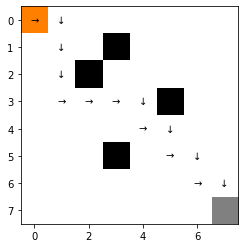

In [7]:
env = MazeEnv(width, height, (0, 0), (width-1, height-1), obstacle_positions)
episode = generate_episode_from_Q(env, Q, 0.00)
plt.imshow(env.render())
for state, action, reward in episode:
    x, y = state
    plt.text(y, x, str(ACTION_LABELS[action]),
    horizontalalignment='center',
    verticalalignment='center')
plt.show()

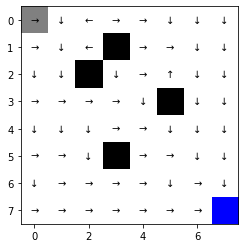

In [8]:
env = MazeEnv(width, height, (0, 0), (width-1, height-1), obstacle_positions)
env.reset()
plt.imshow(env.render())
for x in range(width):
    for y in range(height):
        action = policy.get((x, y), None)
        if action is not None:
            plt.text(y, x, str(ACTION_LABELS[action]),
                horizontalalignment='center',
                verticalalignment='center')
plt.show()


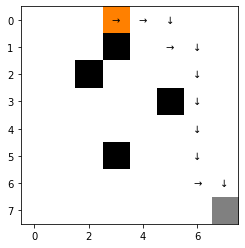

In [9]:
env = MazeEnv(width, height, (0, 3), (width-1, height-1), obstacle_positions)
episode = generate_episode_from_Q(env, Q, 0.00)
plt.imshow(env.render())
for state, action, reward in episode:
    x, y = state
    plt.text(y, x, str(ACTION_LABELS[action]),
    horizontalalignment='center',
    verticalalignment='center')
plt.show()

In [10]:
print(episode)

[((0, 3), 0, -1.0), ((0, 4), 0, -1.0), ((0, 5), 2, -1.0), ((1, 5), 0, -1.0), ((1, 6), 2, -1.0), ((2, 6), 2, -1.0), ((3, 6), 2, -1.0), ((4, 6), 2, -1.0), ((5, 6), 2, -1.0), ((6, 6), 0, -1.0), ((6, 7), 2, 20.0)]


In [11]:
env = MazeEnv(width, height, (5, 2), (width-1, height-1), obstacle_positions)
episode = generate_episode_from_Q(env, Q, 0.00)
print(episode, sum([r for _, _, r in episode]))


[((5, 2), 2, -1.0), ((6, 2), 0, -1.0), ((6, 3), 0, -1.0), ((6, 4), 0, -1.0), ((6, 5), 2, -1.0), ((7, 5), 0, -1.0), ((7, 6), 0, 20.0)] 14.0
